<p><strong>Overview</strong></p>
<p>A steady state algorithm and a genetic algorithm are used to a evolve a genetic program to mimic the output of a test function.</p>

In [127]:
#--Import the required libraries--
import math
import random
import matplotlib.pyplot as plt
import numpy as np

#--debug mode to report on evaluation of tree--
debug_eval = False


<p><strong>Functions</strong></p>
<p>Division was protected by redefing x/0 to be 0, rather then undefined. Square root was protected by defining sqrt(x) to be sqrt(|x|) to avoid complex numbers. All other functions use the equilvent math library function.</p>

In [128]:
#--function definitions the gp will use as nodes--
def mult(x,y):
    return x*y
def add(x,y):
    return x+y
def sub(x,y):
    return x-y

#protected division
def div(x,y):
    if y == 0:
        return 0
    else:
        return x/y
def sin(x):
    return math.sin(x)
def cos(x):
    return math.cos(x)
def floor(x):
    return math.floor(x)

#protected sqrt, where we take the sqrt of the absolute value instead
def sqrt(x):
    return math.sqrt(abs(x))

<p><strong>Settings</strong></p>
<ul>
<li>The range a constant can take is -100 to 100. The precision of these constants is 4 decimal places, in order to avoid floating point errors.</li>
<li>When a node is decided to be a terminal, the probability it is a constant is 0.5. The probability a non_terminal will be selected for crossover is 90%, following the 90/10 rule.</li>
<li>The mutation rate is 20%, meaning the chance a given node will be mutated is 20%.</li>
<li>The maximum depth for a tree is 20, if a tree is larger then this, it will receive a 500&nbsp; point penalty to it's fitness</li>
</ul>

In [129]:
#--define the settings to be used by the GP--

#Possible terminal nodes and the mapping of the names to the value, first is allways the variable
terms = ["var","one","pi","e","const"]
term_map = {"one":1.0,"pi":math.pi,"e":math.e}

#Possible non-terminals and their mapping to the corsponding arrity/function
non_terms = ["+","-","*",'/',"sin","sqrt"]
non_term_map = {"+":add,"-":sub,"*":mult,"/":div,"sin":sin,"floor":floor,"sqrt":sqrt}
non_term_arrity = {"+":2,"-":2,"*":2,"/":2,"sin":1,"floor":1,'sqrt':1}

#range of values a const can take
const_range = (-100,100)
#const precision
const_precision = 4

#probability a term is a const
const_prob = 0.5
#probability a terminal will be selected
term_prob = 0.9
#probability a mutation will occur per node
mutation_rate = 0.2
#max depth
max_depth = 20

<p><strong>Test function</strong></p>
<ul>
<li>&nbsp;The test function is the&nbsp;oscillations that would occur for an A-Major cord, with 1 unit representing 1/1000th of a seccond. (Function found from stack exchange)</li>
<li>The test function is evaluated from -5.0 to 5.0 at intervals of 0.5 in order to determine the fitness of an individual&nbsp;</li>
    
<li>In order to evaluate a individual on the full range, 50 points are used from -10.0 to 10.0. The function is graphed at 100 points.</li>
</ul>

In [130]:
#--Setup for the test function--


#function definition
def test_func(x):
    #A-major cord where 1 = 1/1000th of a seccond
    return math.sin(880.0*math.pi*x/1000.0)+math.sin(1100.0*math.pi*x/1000.0)+math.sin(1320.0*math.pi*x/1000.0)
    
#position of values to evaluate function at
x_values = np.arange(-5.0,5.0,0.5)
y_values = np.asarray([test_func(point) for point in x_values])

#range of values to display
func_range = (-10.0,10.0)
#step size of display
func_graph_points = 100


In [131]:
#--helper functions to plot results--
def make_graph(input_gp, title):
    axis = np.linspace(func_range[0],func_range[1],func_graph_points)
    func_values = np.asarray([input_gp.eval(val) for val in axis])
    test_values = np.asarray([test_func(val) for val in axis])
    plt.plot(axis, test_values, label = "test_func")
    plt.plot(axis, func_values, label = "GP eval")
    plt.grid( linestyle='-')
    plt.xlabel("x-axis")
    plt.ylabel("f(x)")
    plt.ylim(top=5,bottom=-5)
    plt.title(title)
    plt.legend()
    plt.show()

def make_chart(lines, labels, generations, title,x_label,y_max):
    axis = np.arange(generations)
    count = 0
    for line in lines:
        plt.plot(axis, line, label = labels[count])
        count += 1
    plt.xlabel(x_label)
    plt.ylabel("Fitness")
    plt.ylim(top=y_max,bottom=0)
    plt.title(title)
    plt.legend()
    plt.show()


In [132]:
#--Class to represent a node
"""
Represents a node in the expression tree of the gp
"""
class Node:
    def __init__(self, node_type, arrity, node_value=None, childern = []):
        self.node_type = node_type      
        self.arrity = arrity
        self.node_value = node_value
        self.childern = childern
    #evaluate a given node
    def eval(self, var):
        if self.arrity == 2:
            val = non_term_map[self.node_type](self.childern[0].eval(var), self.childern[1].eval(var))
            return val
        elif self.arrity == 1:
            val = non_term_map[self.node_type](self.childern[0].eval(var))
            return val
        elif self.arrity == 0:
            if self.node_type == "const":
                val = self.node_value
                return val
            elif self.node_type == "var":
                return var
            else:
                return term_map[self.node_type]
        else:
            print("Something went very very wrong, arrity wasn't 2 or 0, exiting")
            exit()

    #mutate a node
    def mutate(self):
        if random.random() < mutation_rate:
            if self.arrity == 0:
                if random.random() < const_prob:
                    choice = random.choice(terms[1:])
                    if choice == "const":
                        self.node_type ="const"
                        self.node_value = round(random.uniform(*const_range),const_precision)
                    else:
                        self.node_type = choice
                else:
                    self.node_type = "var"
            elif self.arrity == 1:
                self.node_type = random.choice([func for func in non_terms if non_term_arrity[func] == 1])
            else:
                self.node_type = random.choice([func for func in non_terms if non_term_arrity[func] == 2])
        for child in self.childern:
            child.mutate()
    def __repr__(self):
        if self.arrity == 0:
            if self.node_type == "const":
                return str(self.node_value)
            elif self.node_type == "var":
                return "x"
            else:
                return str(term_map[self.node_type])
        elif self.arrity == 1:
            return self.node_type+"(" + str(self.childern[0])+")"
        else:
            return "("+str(self.childern[0])+self.node_type+str(self.childern[1])+")"

    #copy a node and it's childern
    def copy(self):
        if len(self.childern) == 0:
            return Node(self.node_type, self.arrity, node_value=self.node_value)
        else:
            new_childern = [child.copy() for child in self.childern]
            return Node(self.node_type, self.arrity, node_value=self.node_value, childern=new_childern)

    #shallow copy
    def shallow_copy(self):
        if len(self.childern) == 0:
            return Node(self.node_type, self.arrity, node_value=self.node_value)
        else:
            new_childern = self.childern[:]
            return Node(self.node_type, self.arrity, node_value=self.node_value, childern=new_childern)
    #copys node to another
    def copy_to(self, node):
        node.node_type = self.node_type
        node.arrity = self.arrity
        node.node_value = self.node_value
        node.childern = [child.copy() for child in self.childern]

    #counts non terms
    def count_nt(self):
        count = sum([child.count_nt() for child in self.childern])
        if self.node_type in terms:

            return 0
        else:
            return count + 1
    #counts terms
    def count_t(self):
        count = sum([child.count_t() for child in self.childern])
        if self.node_type in terms:
            return 1
        else:
            return count
                
    #get non terms
    def list_nt(self,list):
        if self.node_type in non_terms:
            list.append(self)
        for child in self.childern:
            child.list_nt(list)
        return

    #get terms
    def list_t(self,list):

        if self.node_type in terms:
            list.append(self)
        for child in self.childern:
            child.list_t(list)
        return
    def depth(self):
        if self.node_type in terms:
            return 1
        else:
            return 1 + max([child.depth() for child in self.childern])


<p><strong>Helper functions</strong></p>
<ul>
<li>&nbsp;Fitness is the average of the euclidian distance between the individuals evaluation, and the test function, at every evaluation point.</li>
<li>Parent selection is tournment selection with 5 individuals&nbsp;</li>
<li>Crossover is <em>subtree crossover</em>*.</li>
<li>Mutation is <em>single point mutation</em>*.&nbsp;</li>
</ul>
<p><em>*as described in "Field guide to Genetic Programming"&nbsp;</em></p>

In [133]:
#--Helper functions for node class
def RandomNode(prob_term):
    if random.random() < prob_term:
        if random.random() < const_prob:
            choice = random.choice(terms[1:])
            if choice == "const":
                return Node("const",0,node_value = round(random.uniform(*const_range),const_precision))
            else:
                return Node(choice,0)
        else:
            return Node("var", 0)
    else:
        choice = random.choice(non_terms)
        return Node(choice,non_term_arrity[choice])

def crossover(a, b):
    #crossover types for a and b
    list_a = []
    list_b = []
    child_a = Tree(0,"copy",a.root.copy())
    child_b = Tree(0,"copy",b.root.copy())
    #pick a terminal 90% of time
    if random.random() < term_prob:
        child_a.root.list_nt(list_a)
    #handle case of a terminal
    else:
        child_a.root.list_t(list_a)
     #pick a terminal 90% of time
    if random.random() < term_prob:
        child_b.root.list_nt(list_b)
    #handle case of a terminal
    else:
        child_b.root.list_t(list_b)



    #don't crossover tree's of size one, because it will break algrithom

    if child_a.root in list_a:
        list_a.remove(child_a.root)
    if child_b.root in list_b:
        list_b.remove(child_b.root)
    if len(list_a) == 0 or len(list_b) == 0:
        return (child_a,child_b)
    
    choice_a = random.choice(list_a)
    choice_b = random.choice(list_b)
    temp = choice_a.shallow_copy()

    choice_b.copy_to(choice_a)
    temp.copy_to(choice_b)
    return (child_a,child_b)
    
def fitness(input):
    tree_y_values = np.asarray([input.eval(val) for val in x_values])
    dist = np.sqrt(np.sum((tree_y_values-y_values)**2))
    penalty = 0
    depth = input.root.depth()
    if depth > max_depth:
        penalty = 500
    return dist + penalty

# evaluate the best fitness over a larger range of the function
def fitness_full(input):
    axis = np.linspace(func_range[0],func_range[1],func_graph_points//2)
    func_values = np.asarray([input.eval(val) for val in axis])
    test_values = np.asarray([test_func(val) for val in axis])

    dist = np.sqrt(np.sum((test_values-func_values)**2))
    return dist

def select_parent(pop):
    selection = random.sample(pop,5)
    return min(selection, key = lambda x: x.fitness)

def place_child(pop, child):
    max_pop = max(pop, key = lambda x: x.fitness)
    if fitness(max_pop) > fitness(child):
        pop[pop.index(max_pop)] = child

In [134]:
#--class to represent tree--
"""
Represents a expression tree for the gp
"""
class Tree:
    def __init__(self, max_depth, init_type, new_root = None):
        self.fitness = 0.0
        if init_type == "grow":
            self.root = self.grow(max_depth,RandomNode(0.5))
            self.fitness = fitness(self)
        elif init_type == "full":
            self.root = self.full(max_depth, RandomNode(0.0))
            self.fitness = fitness(self)
        elif init_type == "copy":
            self.root = new_root
        else:
            print("Error: Please initialize tree")

    def print(self):
        print(self.root)
    def __repr__(self):
        return str(self.root)

    #eval a tree
    def eval(self, var):
        result = self.root.eval(var)
        if debug_eval:
            print("Var: {} Result: {}".format(var, result))
        return result
    def grow(self, grow_depth, current):
        if grow_depth == 1:
            return RandomNode(1.0)
        else:
            if current.arrity == 0:
                return current
            elif current.arrity == 1:
                current.childern = [self.grow(grow_depth -1, RandomNode(0.5))]
                return current
            else:
                current.childern = [self.grow(grow_depth -1,RandomNode(0.5)),self.grow(grow_depth -1,RandomNode(0.5))]
                return current

    def full(self, grow_depth, current):
        if grow_depth == 1:
            return RandomNode(1.0)
        elif current.arrity == 1:
            current.childern = [self.full(grow_depth -1, RandomNode(0.0))]
            return current
        else:
            current.childern = [self.full(grow_depth -1,RandomNode(0.0)),self.full(grow_depth -1,RandomNode(0.0))]
            return current



<p><strong>Steady state algrithom</strong></p>
<p>A generic steady state algrithom is used, with placement of children in population done if the child is better then the worst individual already in the population.</p>
<p>The algrithom is run for 10000 iterations, since 100 iterations is roughly equivalent to a genetic algorithm running for 1 generation.</p>

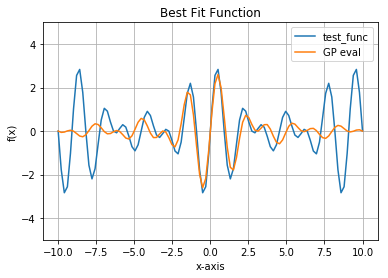

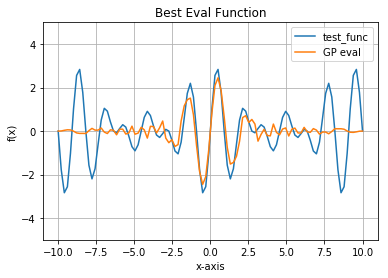

Best fit individual on test interval:
(sin(x)/((x/2.718281828459045)/sin((3.141592653589793*x))))
Distance from test: 7.985289043930531

Best Eval individual on test interval:
(sin(((sin(sqrt(x))*(x*sin((3.141592653589793*x))))-(x*(2.718281828459045/(x-x)))))/((x/2.718281828459045)*sqrt(x)))
Distance from test: 7.852400051350239


In [135]:
random.seed(0)
#steady state algrithom
pop = []
for i in range(0,50):
    pop.append(Tree(5,"grow"))
for i in range(0,50):
    pop.append(Tree(5,"full"))
best_fits = []
avg_fits = []
for gen in range(0,10000):
    a,b = crossover(select_parent(pop),select_parent(pop))
    a.root.mutate()
    b.root.mutate()
    a.fitness = fitness(a)
    b.fitness = fitness(b)
    place_child(pop,a)
    place_child(pop,b)
    best_fits.append(min(pop, key = lambda x: x.fitness).fitness)
    avg_fits.append(sum(map(lambda x: x.fitness,pop))/len(pop))
make_graph(min(pop, key = lambda x: x.fitness),"Best Fit Function")
make_graph(min(pop, key = lambda x: fitness_full(x)),"Best Eval Function")

#copy the results of running the algrithom into new variables to compare against ga
sty_best_fits = best_fits[:]
sty_avg_fits = avg_fits[:]

best_fit_ind = min(pop, key = lambda x: x.fitness)
best_eval_ind = min(pop, key = lambda x: fitness_full(x))
sty_fit = (str(best_fit_ind), fitness_full(best_fit_ind))
sty_eval = (str(best_eval_ind),fitness_full(best_eval_ind))
print("Best fit individual on test interval:\n{}\nDistance from test: {}".format(sty_fit[0],sty_fit[1]))
print()
print("Best Eval individual on test interval:\n{}\nDistance from test: {}".format(sty_eval[0],sty_eval[1]))

<p><strong>Genetic&nbsp;algrithom</strong></p>
<p>A generic genetic algrithom is used, with elitism. The best 6 individuals of the population are preserved.</p>
<p>The algrithom is run for 100 generations.</p>

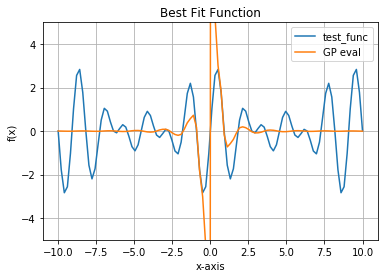

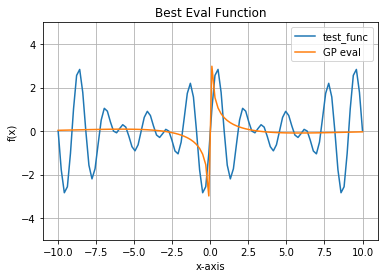

Best fit individual on test interval:
(sin((sin(((x+x)*sqrt(3.141592653589793)))*sqrt((2.718281828459045/x))))/(x*x))
Distance from test: 21.283220168721048

Best Eval individual on test interval:
(sin(sqrt((3.141592653589793*x)))/(x*sqrt(3.141592653589793)))
Distance from test: 8.741978606009049


In [136]:
random.seed(0)
#generational algrithom
pop = []
for i in range(0,50):
    pop.append(Tree(5,"grow"))
for i in range(0,50):
    pop.append(Tree(5,"full"))
best_fits = []
avg_fits = []
#one generation is equilvent to 100 "generations" of the steady state model
for gen in range(0,100):
    new_pop = []
    #perform elitism, preserve the best 6
    pop.sort(key = lambda x: x.fitness)
    for i in range(6):
        new_pop.append(pop[i])
    while len(new_pop) <= 100:
        a,b = crossover(select_parent(pop),select_parent(pop))
        a.root.mutate()
        b.root.mutate()
        a.fitness = fitness(a)
        b.fitness = fitness(b)
        new_pop.append(a)
        new_pop.append(b)
    pop = new_pop
    best_fits.append(min(pop, key = lambda x: x.fitness).fitness)
    avg_fits.append(sum(map(lambda x: x.fitness,pop))/len(pop))
make_graph(min(pop, key = lambda x: x.fitness),"Best Fit Function")
make_graph(min(pop, key = lambda x: fitness_full(x)),"Best Eval Function")

gen_best_fits = best_fits[:]
gen_avg_fits = avg_fits[:]

best_fit_ind = min(pop, key = lambda x: x.fitness)
best_eval_ind = min(pop, key = lambda x: fitness_full(x))
gen_fit = (str(best_fit_ind), fitness_full(best_fit_ind))
gen_eval = (str(best_eval_ind),fitness_full(best_eval_ind))
print("Best fit individual on test interval:\n{}\nDistance from test: {}".format(gen_fit[0],gen_fit[1]))
print()
print("Best Eval individual on test interval:\n{}\nDistance from test: {}".format(gen_eval[0],gen_eval[1]))

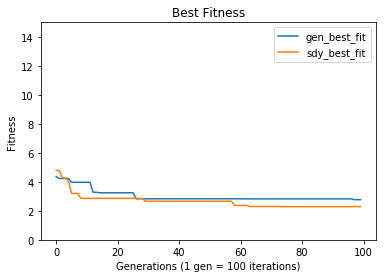

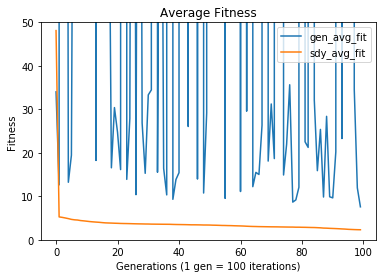

In [137]:
#100 iterations of the steady state model is equilvent to 1 generation, so only append data from every 100
new_sty_best_fits = []
new_sty_avg_fits = []
for i in range(0,10000,100):
    new_sty_best_fits.append(sty_best_fits[i])
    new_sty_avg_fits.append(sty_avg_fits[i])

best_plot_list = [gen_best_fits,new_sty_best_fits]
best_title_list = ["gen_best_fit","sdy_best_fit"]
make_chart(best_plot_list,best_title_list,100,"Best Fitness","Generations (1 gen = 100 iterations)",15)

avg_plot_list = [gen_avg_fits, new_sty_avg_fits]
avg_title_list = ["gen_avg_fit","sdy_avg_fit"]
make_chart(avg_plot_list,avg_title_list,100,"Average Fitness","Generations (1 gen = 100 iterations)",50)


<p><strong>Results</strong></p>
<p>The SSA(Steady State&nbsp;Algorithm) performed much better then the GA(Genetic Algorithm). The best individual (minimum evaluation on full range) of the SSA had a euclidian distance from the test function of approximately 7.9, while the GA was 8.7.</p>
<p>Visually, the SSA is a much more accurate representation of the test function, while the GA appears to be cutting through the middle, allowing it to be close, without accurately approximating the function.&nbsp;</p>
<p>The individual with the best fitness on the evaluation range of the SSA was also close to the best evaluation on the full range, suggesting a lack of diversity in the population, which is to be expected with a SSA.&nbsp;</p>
<p>The best fitness of any particular generation(or 100 iterations) of the GA was remarkably close to the SSA, meaning they converged a similar rates. The average of the GA had a lot of variance, which is typical of a GA, since some children will have much worse fitness then their parents. The SSA's average fitness steadily decreased, which is also typical, since a individual will not enter the population if it is worse then it's parents.&nbsp;</p>
<p><strong>Conclusion</strong></p>
<p>The reason the SSA probably performed much better was because trees can have a lot of diversity, so the SSA spent the 10000 iterations refining the initial population to better fit the function, while the GA could have destroyed useful genetic material. This of course, could lead the SSA to overfitting a given set of a data points, and may not generalize well to higher dimension functions.</p>
<p>&nbsp;</p>